### In this notebook, we are going to implement the PandasAgent constructed by LangChain as one of the methods to answer some questions regarding the Chronic  Disease Dataset.

Firstly, we are going to import the required libraries from langchain https://python.langchain.com/docs/get_started/introduction

In [1]:
from langchain.agents.agent_types import AgentType
from langchain.chat_models import ChatOpenAI
from langchain.chat_models.azure_openai import AzureChatOpenAI
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
import pandas as pd

Then, we read our dataframe resulted from preprocessing data files. We are going to work with the unpivotted table format.

In [2]:
df = pd.read_csv("Loading_PreprocessingData/filtered_data.csv", low_memory = False)

In [3]:
df.head(5)

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,DataValueFootnoteSymbol,DatavalueFootnote,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1,GeoLocation,ProcessedDataValue,ProcessedDataValue_z_score
0,2014,2014,AR,Arkansas,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,Number,916,NaN,NaN,NaN,NaN,Gender,Male,POINT (-92.27449074299966 34.74865012400045),NaN,NaN
1,2018,2018,CO,Colorado,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,Number,2227,NaN,NaN,NaN,NaN,Overall,Overall,POINT (-106.13361092099967 38.843840757000464),NaN,NaN
2,2018,2018,DC,District of Columbia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,Number,708,NaN,NaN,NaN,NaN,Overall,Overall,POINT (-77.036871 38.907192),NaN,NaN
3,2017,2017,GA,Georgia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,Number,3520,NaN,NaN,NaN,NaN,Gender,Female,POINT (-83.62758034599966 32.83968109300048),NaN,NaN
4,2010,2010,MI,Michigan,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,Number,123,NaN,NaN,NaN,NaN,Race/Ethnicity,Hispanic,POINT (-84.71439026999968 44.6613195430005),NaN,NaN


Now, we are calling the Azure API to create our LLM using GPT-4 as our main model.
Remember you might need to change AzureChatOpenAI to ChatOpenAI. We are mainly using 'Chat' since we are creating a chatbot.

In [4]:
llm =  AzureChatOpenAI(
    openai_api_type = "azure",
    openai_api_base = "https://xxxxxxxxxxxx.openai.azure.com/",
    openai_api_version = "xxxx-xx-xx-preview",
    deployment_name='GPT-4',
    openai_api_key = "xxxxxxxxxxxxxxxxxxxxxxxxxxxx")

Let's use our agent. The agent should be able to get answers from the dataframe by writing python code, and finally, chat with the user.

We will use the agent's default parameters. We will enable the verbose so that you can see how the agent works.

In [5]:
agent = create_pandas_dataframe_agent(llm, df, verbose=True)

Here are the agent parameters

In [6]:
print(agent)

verbose=True agent=ZeroShotAgent(llm_chain=LLMChain(prompt=PromptTemplate(input_variables=['agent_scratchpad', 'input'], partial_variables={'df_head': '|    |   YearStart |   YearEnd | LocationAbbr   | LocationDesc         | DataSource   | Topic   | Question                    |   DataValueUnit | DataValueType   |   DataValue |   DataValueFootnoteSymbol |   DatavalueFootnote |   LowConfidenceLimit |   HighConfidenceLimit | StratificationCategory1   | Stratification1   | GeoLocation                                    |   ProcessedDataValue |   ProcessedDataValue_z_score |\n|---:|------------:|----------:|:---------------|:---------------------|:-------------|:--------|:----------------------------|----------------:|:----------------|------------:|--------------------------:|--------------------:|---------------------:|----------------------:|:--------------------------|:------------------|:-----------------------------------------------|---------------------:|---------------------------

Let's try the agent

In [7]:
agent.run('Hi')



> Entering new AgentExecutor chain...
Thought: This does not seem like a valid question. It seems more like a greeting.
Final Answer: Hello! How can I assist you today?

> Finished chain.


'Hello! How can I assist you today?'

In [8]:
agent.run('List Cancer related indicators available in the dataset.')



> Entering new AgentExecutor chain...
Thought: To list cancer related indicators available in the dataset, we need to filter the dataframe where the Topic column contains the word "Cancer". Then, we will select the unique values in the Question column of the filtered dataframe. 
Action: python_repl_ast
Action Input: cancer_related_indicators = df[df['Topic'].str.contains('Cancer')]['Question'].unique()
Observation: 
Thought:I have filtered the dataframe to include only rows where the Topic is 'Cancer'. I have then selected the unique values from the 'Question' column. Now, I need to print these values to see the cancer related indicators in the dataset.
Action: python_repl_ast
Action Input: print(cancer_related_indicators)
Observation: ['Cancer of the oral cavity and pharynx, mortality'
 'Cancer of the prostate, mortality'
 'Invasive cancer (all sites combined), mortality'
 'Cancer of the female breast, mortality'
 'Cancer of the female cervix, mortality'
 'Cancer of the colon and re

'The cancer related indicators available in the dataset are: \n\n1. Cancer of the oral cavity and pharynx, mortality\n2. Cancer of the prostate, mortality\n3. Invasive cancer (all sites combined), mortality\n4. Cancer of the female breast, mortality\n5. Cancer of the female cervix, mortality\n6. Cancer of the colon and rectum (colorectal), mortality\n7. Cancer of the lung and bronchus, mortality\n8. Invasive melanoma, incidence\n9. Melanoma, mortality\n10. Invasive cancer of the oral cavity or pharynx, incidence\n11. Invasive cancer of the prostate, incidence\n12. Invasive cancer (all sites combined), incidence\n13. Invasive cancer of the female breast, incidence\n14. Invasive cancer of the cervix, incidence\n15. Cancer of the colon and rectum (colorectal), incidence\n16. Cancer of the lung and bronchus, incidence\n17. Mammography use among women aged 50-74 years\n18. Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50-75 years\n19. Recent Papanicolaou smear use

Now, let's create our chatbot using the Gradio library in Python!
We'll disable the verbosity. However, it's a good idea to enable verbosity to observe how the agent approaches the problem and tackles potential challenges.

In [9]:
agent = create_pandas_dataframe_agent(llm, df, verbose=False)

In [10]:
from langchain.schema import AIMessage, HumanMessage
import time
import gradio as gr

def predict(message, history):
    history_langchain_format = []
    for human, ai in history:
        history_langchain_format.append(HumanMessage(content=human))
        history_langchain_format.append(AIMessage(content=ai))
    history_langchain_format.append(HumanMessage(content=message))
    
    gpt_response = agent.run(message)
    
    
    response_message = ""
    for character in gpt_response:
        response_message += character
        time.sleep(0.01)
        yield response_message
    
# Create a Gradio interface
chat_interface = gr.ChatInterface(predict)

# Enable the queue
chat_interface.queue()

# Launch the Gradio interface
chat_interface.launch()

## this line if you want to share the chatbot with others and make an authenticator
#chat_interface.launch(share = True, auth=("admin", "pass1234"))

Running on local URL:  http://127.0.0.1:7877

To create a public link, set `share=True` in `launch()`.


Here is a sample of the output:

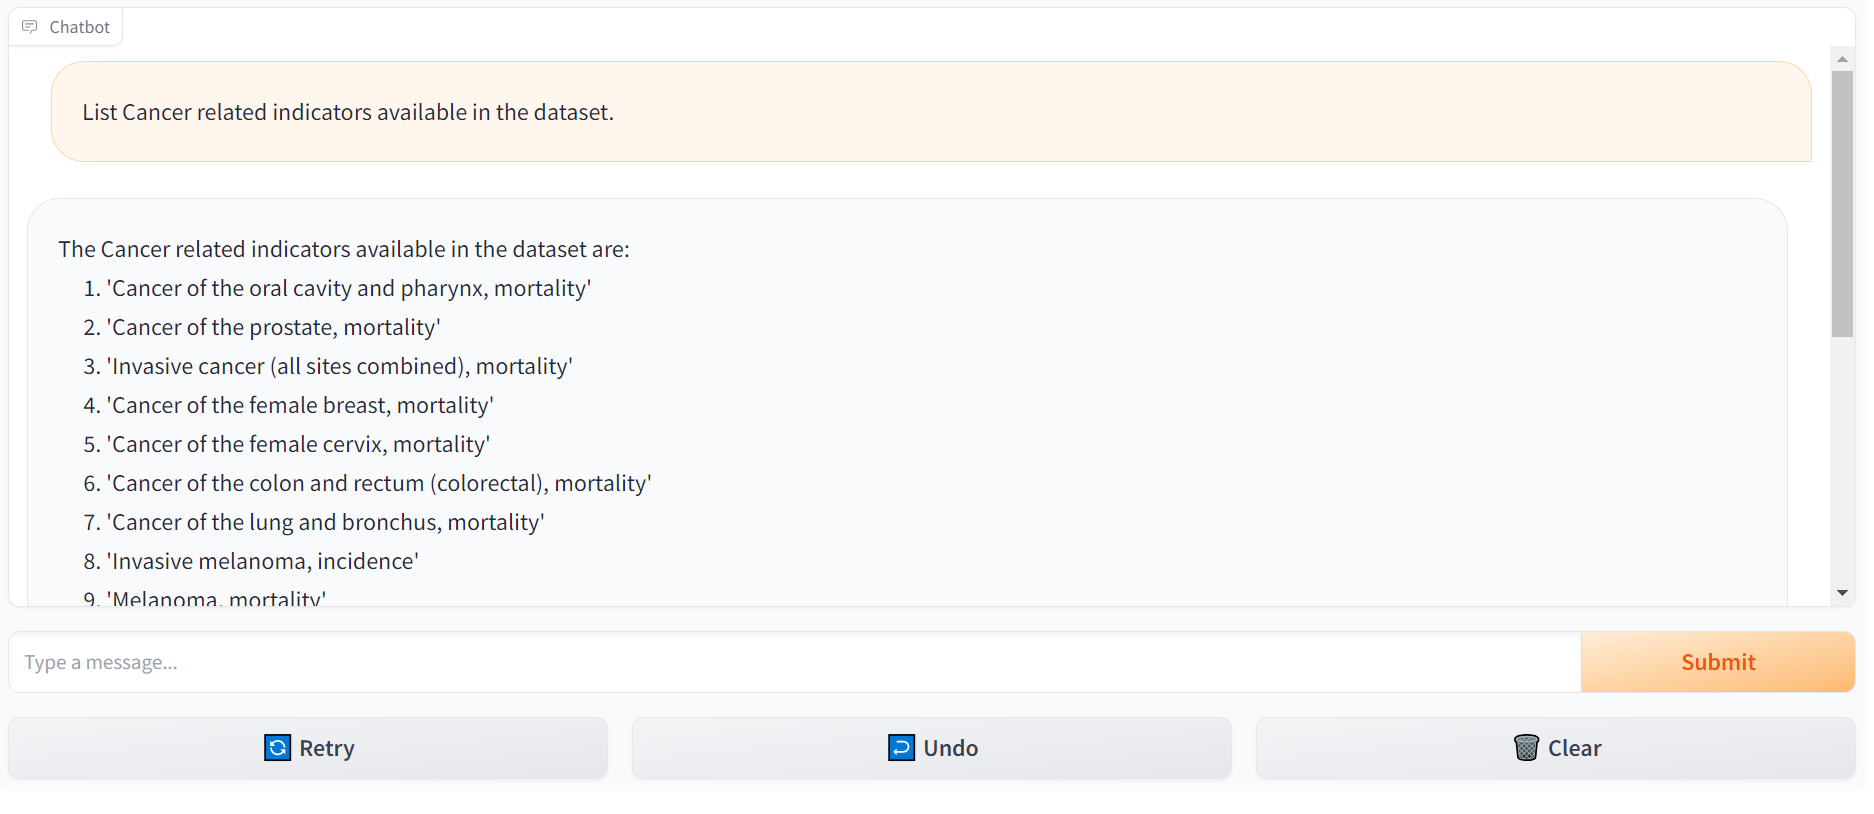

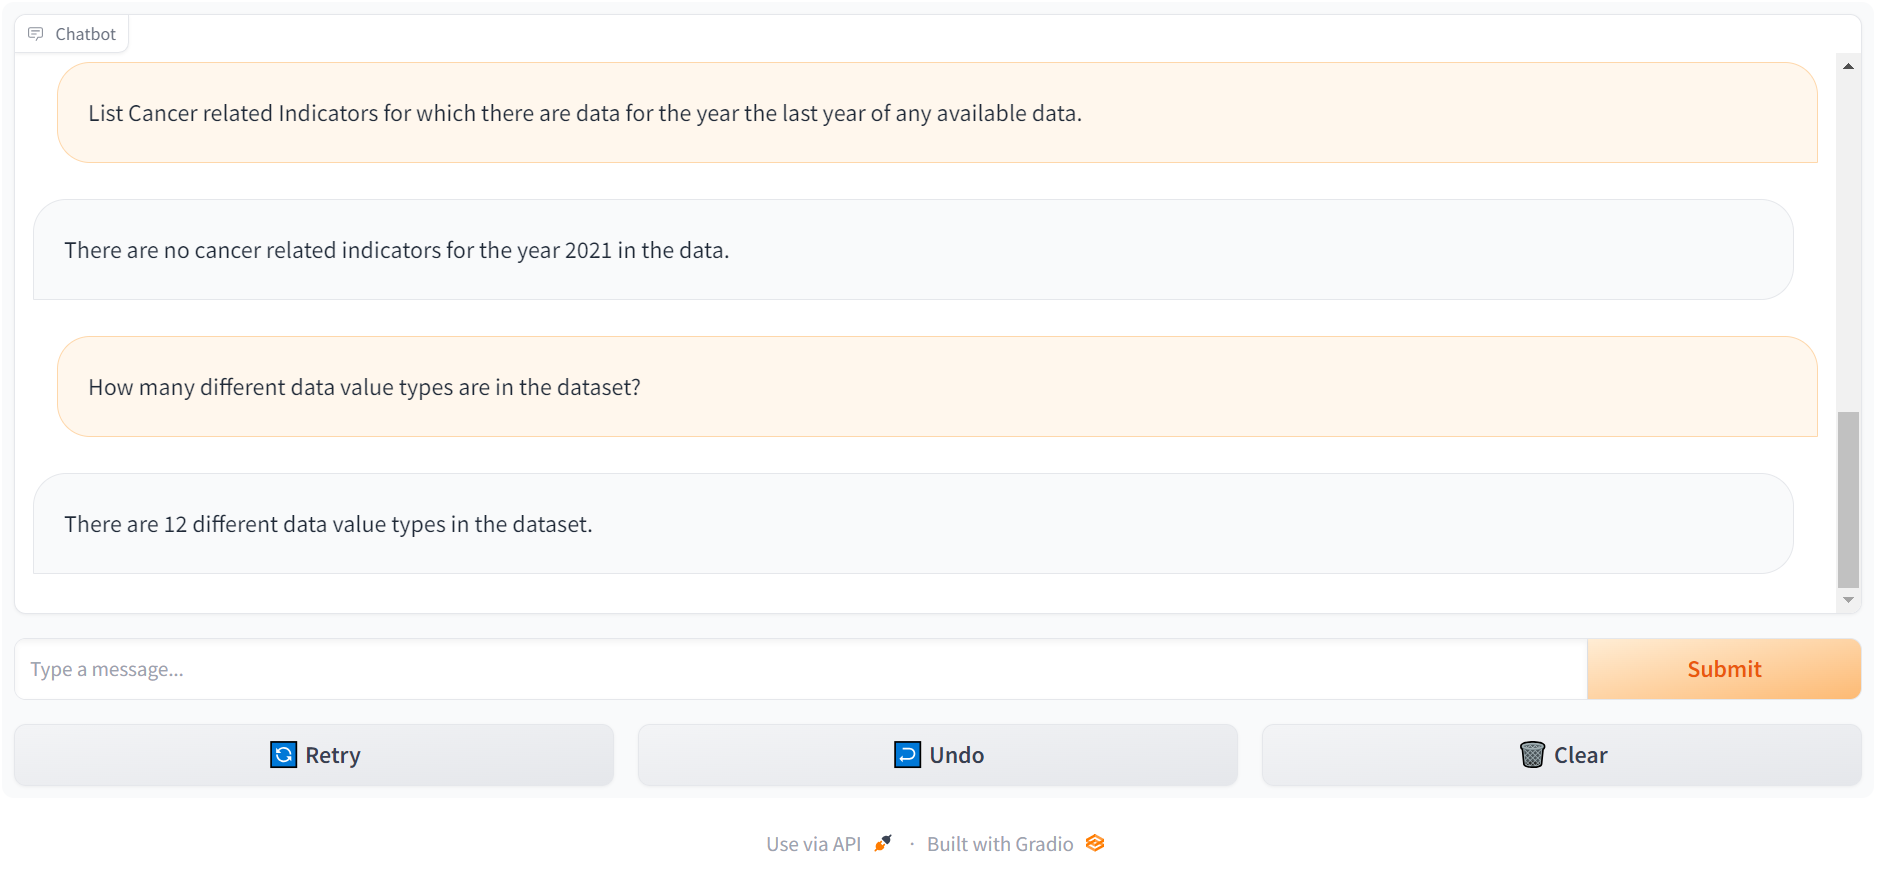

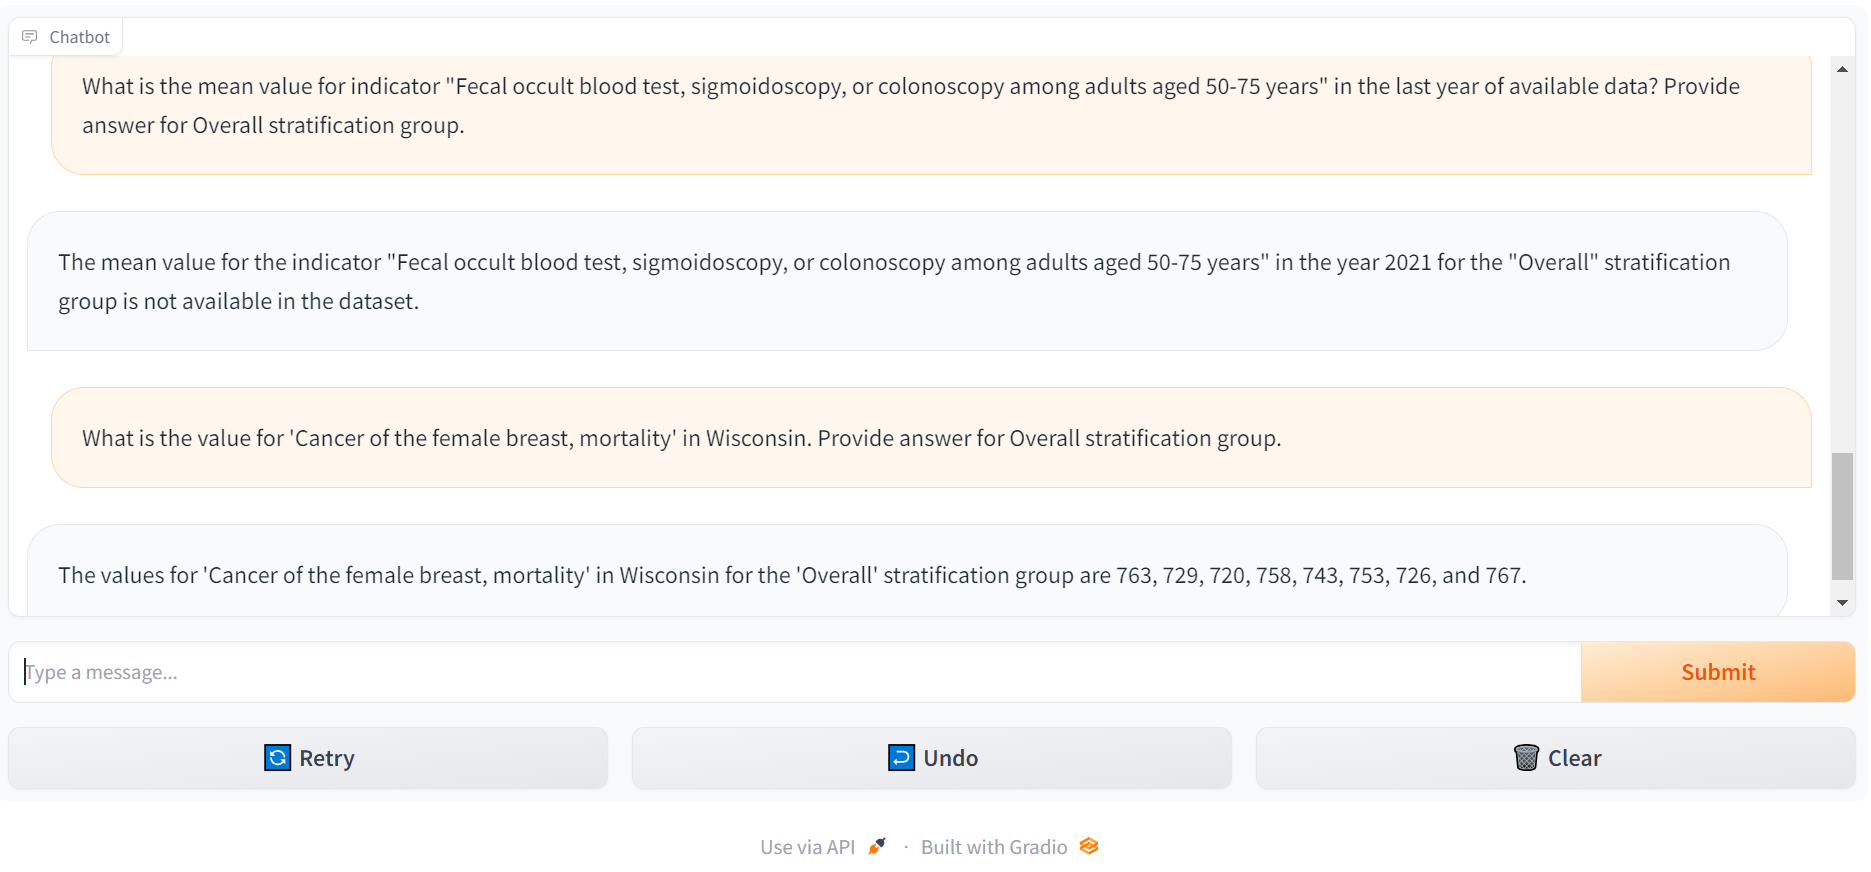

Interesting!

Here are some sample evaluation questions we use to assess the performance of the various language model methods we're implementing:

In [11]:
# List Cancer related indicators available in the dataset.

answer_1 = df[df.Topic == 'Cancer']['Question'].unique()
answer_1

array(['Cancer of the oral cavity and pharynx, mortality',
       'Cancer of the prostate, mortality',
       'Invasive cancer (all sites combined), mortality',
       'Cancer of the female breast, mortality',
       'Cancer of the female cervix, mortality',
       'Cancer of the colon and rectum (colorectal), mortality',
       'Cancer of the lung and bronchus, mortality',
       'Invasive melanoma, incidence', 'Melanoma, mortality',
       'Invasive cancer of the oral cavity or pharynx, incidence',
       'Invasive cancer of the prostate, incidence',
       'Invasive cancer (all sites combined), incidence',
       'Invasive cancer of the female breast, incidence',
       'Invasive cancer of the cervix, incidence',
       'Cancer of the colon and rectum (colorectal), incidence',
       'Cancer of the lung and bronchus, incidence',
       'Mammography use among women aged 50-74 years',
       'Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50-75 years',
      

In [12]:
# List Cancer related Indicators for which there are data for the year the last year of any available data.
answer_2 =  len(df[(df.Topic == 'Cancer') & (df.YearStart == df.YearStart.max())])
answer_2

0

In [13]:
# How many diferent datat value types are in the dataset?
answer_3 = len(df['DataValueType'].unique())
answer_3

12

In [14]:
# What is the mean value for indicator 'Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50-75 years' in the last year of available data? Provide answer for Overall stratification group.

max_year = df[df.Question == 'Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50-75 years']['YearStart'].max()

answer_4 = df[(df.Question == 'Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50-75 years') & (df.YearStart == max_year) & (df.Stratification1 == "Overall")]['DataValue'].astype(float).mean()
answer_4

73.12222222222222

In [15]:
# What is the value for 'Cancer of the female breast, mortality' in Wisconsin. Provide answer for Overall stratification group.

answer_5 = df[(df.Question == 'Cancer of the female breast, mortality') & (df.Stratification1 == 'Overall') & (df.LocationAbbr == 'WI')][['YearStart', 'YearEnd', 'DataValue']].sort_values(by='YearStart', ascending=False)
answer_5

,YearStart,YearEnd,DataValue
18180,2015,2019,720
17772,2014,2018,729
18992,2013,2017,726
18543,2012,2016,743
18720,2011,2015,753
17331,2010,2014,763
19238,2009,2013,767
18357,2008,2012,758


Actually, the agent aced 4 out of 5 questions (the last question with an incomplete answer). Great job! 🌟

That's it! Give it a go on your own.

That concludes the PandasAgent developed by LangChain. To enhance its performance, consider fine-tuning its parameters and experimenting with different approaches. For instance, a useful suggestion is to provide the agent with the unique values of categorical columns to prevent receiving an answer like "The data is not provided" (sometimes it's provided, but the agent cannot capture the value in the dataframe).

Additionally, it's beneficial to simplify the column names to enhance the agent's understanding.
Another potential enhancement is providing the agent with a clear problem objective and description.

Surprisingly, sometimes the agent needs its time to think and take its "breath" after many answers.

There are several aspects to consider for enhancements. In this project, we are just exploring the power of LLMs.